## Deliverable 1

# 1. Identifying business needs

Cars 4 is an online car resale company. Their business model involves sending clients’ cars to mechanics for evaluation in order to determine their market value and then purchasing the cars from the clients at that price.

As the company grew in popularity, the mechanics’ waiting list became increasingly long, causing delays and driving potential clients toward competitors.

Our goal is to develop a predictive model capable of estimating a car’s real market price based on several key features. We have access to a dataset from 2020, which will allow us to train and compare different models to determine which one performs best at predicting car prices.


Models we are going to test:
- [...]

# 2. Data Exploration and Preprocessing

We start by importing the necessary libraries and the data sets (test and training). However, we will be mainly working with the training data set and basing our decisions on its key aspects.

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl 




In [110]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [111]:
df_train.head()

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0


In [112]:
df_test.head()

,carID,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,89856,Hyundai,I30,2022.878006,Automatic,30700.000000,petrol,205.0,41.5,1.6,61.0,3.0,0.0
1,106581,VW,Tiguan,2017.000000,Semi-Auto,-48190.655673,Petrol,150.0,38.2,2.0,60.0,2.0,0.0
2,80886,BMW,2 Series,2016.000000,Automatic,36792.000000,Petrol,125.0,51.4,1.5,94.0,2.0,0.0
3,100174,Opel,Grandland X,2019.000000,Manual,5533.000000,Petrol,145.0,44.1,1.2,77.0,1.0,0.0
4,81376,BMW,1 Series,2019.000000,Semi-Auto,9058.000000,Diesel,150.0,51.4,2.0,45.0,4.0,0.0


Price is the target andd the rest are features!

In [113]:
# changing carID to index

df_train.set_index('carID', inplace = True)
df_test.set_index('carID', inplace=True)

In [114]:
df_train.shape
# we have 75973 cars and 13 features

(75973, 13)

In [115]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75973 entries, 69512 to 15795
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           74452 non-null  object 
 1   model           74456 non-null  object 
 2   year            74482 non-null  float64
 3   price           75973 non-null  int64  
 4   transmission    74451 non-null  object 
 5   mileage         74510 non-null  float64
 6   fuelType        74462 non-null  object 
 7   tax             68069 non-null  float64
 8   mpg             68047 non-null  float64
 9   engineSize      74457 non-null  float64
 10  paintQuality%   74449 non-null  float64
 11  previousOwners  74423 non-null  float64
 12  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 8.1+ MB


In [116]:
features = ['Brand', 'model', 'year', 
            'transmission', 'mileage', 'fuelType', 
            'tax', 'mpg', 'engineSize', 'paintQuality%', 
            'previousOwners', 'hasDamage' ]

cat_feats = ['Brand', 'model', 
            'transmission', 'fuelType', 'hasDamage' ]

num_feats = ['year', 'mileage','tax', 'mpg', 'engineSize', 
             'paintQuality%', 'previousOwners' ]

for i in features:
    print('- ',i, ' has ', df_train[i].isna().sum(), ' NaN values')

-  Brand  has  1521  NaN values
-  model  has  1517  NaN values
-  year  has  1491  NaN values
-  transmission  has  1522  NaN values
-  mileage  has  1463  NaN values
-  fuelType  has  1511  NaN values
-  tax  has  7904  NaN values
-  mpg  has  7926  NaN values
-  engineSize  has  1516  NaN values
-  paintQuality%  has  1524  NaN values
-  previousOwners  has  1550  NaN values
-  hasDamage  has  1548  NaN values


Using the .info() method we can already spot some issues:
- 'year' datatype should be int64
- 'previousOwners' datatype should be int64
- 'hasDamage' datatype should be boolean
- every feature has A LOT of missing values

We should also divide the training set into a train and a validation subsets in order to train our models. The test set is saved for a final chance at validation.


In [117]:

"""

# separating features from target
X = df_train.drop('price', axis=1)
y = df_train['price']



X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3, 
                                                           random_state = 0, 
                                                            shuffle = True)

# random state seed makes the code reproducible (every time it runs we get the same split)
# shuffle=True randomly suffles the data set before splitting to avoid bias
# stratify ensures balance between sets (same proportion of y classes in both) but we won't be using it because price is not categorical !!
# this is a regression problem

"""

"\n\n# separating features from target\nX = df_train.drop('price', axis=1)\ny = df_train['price']\n\n\n\nX_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3, \n                                                           random_state = 0, \n                                                            shuffle = True)\n\n# random state seed makes the code reproducible (every time it runs we get the same split)\n# shuffle=True randomly suffles the data set before splitting to avoid bias\n# stratify ensures balance between sets (same proportion of y classes in both) but we won't be using it because price is not categorical !!\n# this is a regression problem\n\n"

For a first approach, we can substitute the missing values in the categorical variables with 'Unknown' and in the numerical variables with the median of that variable.

In [118]:
"""

for i in cat_feats:
    X_train[i] = X_train[i].fillna('Unknown')
    X_val[i] = X_val[i].fillna('Unknown')

for j in num_feats:
    X_train[j] = X_train[j].fillna(X_train[j].median())
    X_val[j] = X_val[j].fillna(X_train[j].median())

X_train.info()

"""


"\n\nfor i in cat_feats:\n    X_train[i] = X_train[i].fillna('Unknown')\n    X_val[i] = X_val[i].fillna('Unknown')\n\nfor j in num_feats:\n    X_train[j] = X_train[j].fillna(X_train[j].median())\n    X_val[j] = X_val[j].fillna(X_train[j].median())\n\nX_train.info()\n\n"

In [119]:
"""

# Now we can typecast the other variables

X_train['year'] = X_train['year'].astype('int64')
X_train['previousOwners'] = X_train['previousOwners'].astype('int64')
X_train['hasDamage'] = X_train['hasDamage'].astype('bool')


X_val['year'] = X_val['year'].astype('int64')
X_val['previousOwners'] = X_val['previousOwners'].astype('int64')
X_val['hasDamage'] = X_val['hasDamage'].astype('bool')


"""

"\n\n# Now we can typecast the other variables\n\nX_train['year'] = X_train['year'].astype('int64')\nX_train['previousOwners'] = X_train['previousOwners'].astype('int64')\nX_train['hasDamage'] = X_train['hasDamage'].astype('bool')\n\n\nX_val['year'] = X_val['year'].astype('int64')\nX_val['previousOwners'] = X_val['previousOwners'].astype('int64')\nX_val['hasDamage'] = X_val['hasDamage'].astype('bool')\n\n\n"

# Data Description

Let us try to find the key insights about this data set.

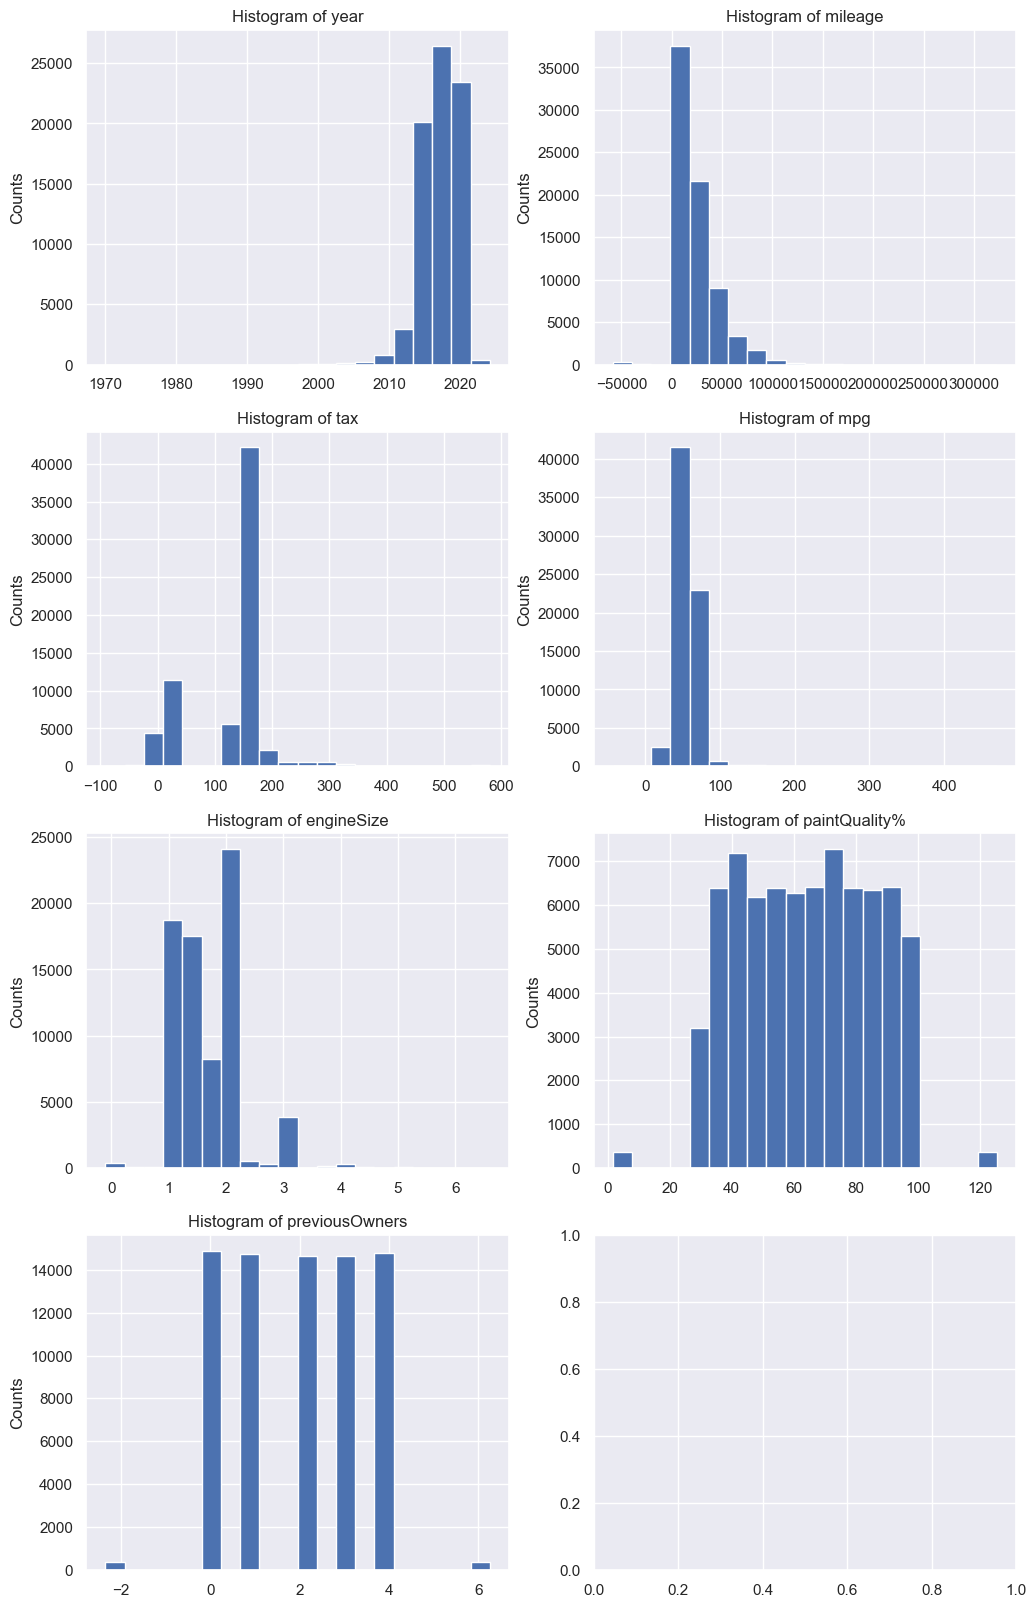

In [120]:
# non-scaled just for insight

fig, axes = plt.subplots(4, 2, figsize=(12, 20))
axes = axes.flatten()

sns.set_style('whitegrid')

for i, var in enumerate(num_feats):
    axes[i].hist(df_train[var], 20)
    axes[i].set_title(f'Histogram of {var}')
    axes[i].set_ylabel('Counts')

plt.tight_layout
plt.show()

We can spot more issues right away:

*Cat Vars*
- the categories are wrongly typed (brands, transmission, fuel type and models); 

*Num Vars*
- negative mileage values
- negative tax values
- engine size <=0
- paintquality values above 100%
- negative number of previous owners
(these are all errors, meaning they are not possible in the context of the variable)

In [121]:
#------------------ Fixing brand categories: ---------------------

car_brands = {
    "Volkswagen": ['VW', 'V', 'vw', 'v'],
    "Toyota": ['Toyota', 'Toyot', 'TOYOTA', 'oyota', 'toyota', 'OYOTA', 'TOYOT', 'toyot','oyot' ],
    "Audi": ['Audi', 'udi', 'AUDI', 'aud', 'audi', 'Aud', 'aud', 'UDI', 'ud', 'AUD'],
    "Ford": ['Ford', 'FOR', 'ord', 'For', 'FORD', 'ford', 'for', 'or', 'ORD'],
    "BMW": ['BMW', 'w', 'MW', 'bmw', 'BM', 'W', 'mw','bm'],
    "Skoda": ['Skoda', 'SKOD', 'koda', 'skoda', 'SKODA', 'Skod', 'kod', 'SKOD', 'KODA', 'skod'],
    "Opel": ['Opel', 'Ope', 'opel', 'pel', 'pe', 'OPEL', 'PEL', 'OPE', 'ope'],
    "Mercedes": ['Mercedes', 'mercedes', 'Mercede', 'MERCEDES', 'ercedes', 'mercede', 'ERCEDES', 'ercede', 'MERCEDE','M'],
    "Hyundai": ['Hyundai', 'yundai', 'Hyunda', 'hyundai', 'HYUNDAI', 'yunda', 'HYUNDA', 'hyunda','YUNDAI']
}


for brand, typos in car_brands.items():
    df_train['Brand'] = df_train['Brand'].apply(lambda x: brand if x in typos else x )
    df_test['Brand'] = df_test['Brand'].apply(lambda x: brand if x in typos else x )



df_test['Brand'].unique()
# Brands: ['Mercedes', 'Opel', 'Ford', 'Volkswagen', 'Toyota', 'Unknown','BMW', 'Skoda', 'Audi', 'Hyundai']

array(['Hyundai', 'Volkswagen', 'BMW', 'Opel', 'Ford', 'Mercedes',
       'Skoda', 'Toyota', 'Audi', nan], dtype=object)

In [122]:
# -----------------Fixing transmission categories ------------------



transmission_types = {
    "Semi_auto": ['Semi-Auto', 'Semi-Aut', 'SEMI-AUTO', 'semi-auto', 'emi-auto', 'SEMI-AUT', 'emi-auto', 'emi-Aut', 'semi-aut', 'EMI-AUTO', 'emi-Auto'],
    "Manual": ['Manual', 'Manua', 'MANUAL', 'manual', 'anual', 'Manual', 'ANUAL', 'Manual ', ' manual ', 'anua', ' MANUAL ', 'MANUA', 'manua', ' Manual', 'manual ', ' Manual '],
    "Automatic": ['Automatic', 'Automati', 'utomatic', 'AUTOMATIC', 'automatic', 'AUTOMATI', 'automati', 'UTOMATIC', 'utomati'],
    "Unknown": ['Unknown', 'unknown', 'nknown', 'UNKNOWN', 'nknow', 'unknow'] }


for trans, typos in transmission_types.items():
    df_train['transmission'] = df_train['transmission'].apply(lambda x: trans if x in typos else x )
    df_test['transmission'] = df_test['transmission'].apply(lambda x: trans if x in typos else x )

df_test['transmission'].unique()


array(['Automatic', 'Semi_auto', 'Manual', 'Unknown', nan, 'Other'],
      dtype=object)

In [123]:
# ----------------Fixing fuelType ----------------------


fuel_types = {
    "Diesel": ['Diesel', 'Diese', 'iesel', 'DIESEL', 'diesel', 'diese', 'IESEL', 'DIESE', 'iese', 'IESE'],
    "Petrol": ['petrol', 'Petrol', 'ETROL', 'Petro', 'etrol', 'PETROL', 'PETRO', 'etro', 'petro', 'ETRO'],
    "Hybrid": ['Hybrid', 'hybrid', 'Hybri', 'HYBRID', 'ybrid', 'HYBRI', 'ybri', 'YBRID','hybri'],
    "Other": ['Other', 'OTHER', 'Othe', 'ther', 'other']
}

for fuel, typos in fuel_types.items():
    df_train['fuelType'] = df_train['fuelType'].apply(lambda x: fuel if x in typos else x )
    df_test['fuelType'] = df_test['fuelType'].apply(lambda x: fuel if x in typos else x )



df_test['fuelType'].unique() #fuelType categories:  '['Diesel', 'Petrol', 'Hybrid', 'Unknown', 'Other', 'Electric']



array(['Petrol', 'Diesel', 'Hybrid', nan, 'Other', 'Electric'],
      dtype=object)

In [124]:
# --------- FIXING CAR MODELS -------------------

car_models = {
    "GOLF": ['Golf', 'Gol', ' GOLF', ' golf', ' golf s', ' Gol', ' Golf SV', ' golf sv', 'Golf', 'golf', ' GOLF', ' Golf S', ' gol', ' GOL', ' Golf'],
    "POLO": ['Polo', 'Pol', 'polo', ' POLO', ' polo', ' Pol', ' Polo', 'POLO'],
    "PASSAT": ['Passat', ' PASSAT', ' Passa', ' passa', ' Passa', ' Passa', ' passat', ' Passat'],
    "TIGUAN": ['Tiguan', ' Tiguan', ' TIGUAN', 'Tigua', ' tiguan', ' Tigua', ' TIGUA', ' tiguan', ' Tiguan', 'TIGUAN', 'tiguan'],
    "TIGUAN_ALLSPACE": [' tiguan allspace', ' Tiguan Allspac', 'Tiguan Allspace', ' TIGUAN ALLSPACE', ' Tiguan Allspace'],
    "TOUAREG": ['Touareg', ' TOUAREG', ' touareg', ' Touare', ' Touareg'],
    "T_ROC": ['T-Roc', ' T-Ro', ' t roc', ' T-Roc'],
    "T_CROSS": ['T-Cross', ' T-CROSS', ' t-cros', ' t cross', ' T-Cros', ' T-RO', ' T-ROC', ' t-roc', ' t-cross', 'T-Cross', ' T-Cross'],
    "ARTEON": ['Arteon', ' arteon', ' Arteo', ' ARTEON', ' Arteon'],
    "SHARAN": ['Sharan', ' sharan', ' SHARAN', ' Shara', ' Sharan', ' Sharan'],
    "JETTA": ['Jetta', ' Jetta', ' JETTA'],
    "CC": ['CC', ' cc', ' CC'],
    "CARAVELLE": ['Caravelle', ' caravelle', ' Caravell', ' Caravelle'],
    "CALIFORNIA": ['California', ' California'],
    "CADDY": ['Caddy', ' Caddy'],
    "CADDY_MAXI": ['Caddy Maxi Life', ' Caddy Maxi Lif', ' Caddy Maxi', ' Caddy Maxi Life', ' Caddy Life'],
    "TOURAN": ['Touran', ' touran', ' TOURAN', ' Touran', 'Toura', ' TOURA', ' Toura'],
    "GOLF_SV": ['Golf SV', 'Golf S', ' golf sv', ' GOLF SV', 'Golf SV'],
    "BEETLE": ['Beetle', ' beetle', ' Beetl', ' Beetle'],
    "SCIROCCO": ['Scirocco', ' scirocco', ' Scirocc', ' SCIROCCO', ' Scirocco'],
    "UP": ['Up', ' up', ' UP', ' Up', ' U', 'U', 'UP'],
    "AMAROK": ['Amarok', ' Amarok', ' amarok', ' Amaro'],
    "EOS": ['Eos', ' Eos'],
    "FOX": ['Fox', ' Fox'], "FOCUS": ['Focus', 'FOCUS', ' focus', ' FOCUS', ' FOCU', ' Focu', ' focu', ' Focus', 'Focu', 'focus'],
    "FIESTA": ['Fiesta', ' FIESTA', ' Fiest', 'fiesta', ' fiesta', ' Fiest', ' FIEST', ' fiest', ' Fiesta', 'Fiest'],
    "MONDEO": ['Mondeo', ' MONDEO', ' mondeo', ' Monde', ' MONDE', ' Mondeo'],
    "KUGA": ['Kuga', ' KUGA', ' kuga', ' Kug', ' kuga', ' Kuga', 'kuga'],
    "GALAXY": ['Galaxy', ' GALAXY', ' Galax', ' galax', ' Galaxy', ' galaxy'],
    "S_MAX": ['S-MAX', ' s-max', ' S-MA', ' s-ma', ' S-MAX'],
    "B_MAX": ['B-MAX', ' B-MA', ' b-max', ' B-MA', ' B-MAX', 'B-MA'],
    "ECOSPORT": ['EcoSport', ' ecosport', ' ECOSPORT', ' EcoSpor', ' EcoSport'],
    "PUMA": ['Puma', ' puma', ' PUMA', ' Puma'],
    "TOURNEO_CUSTOM": ['Tourneo Custom', ' tourneo custom', ' Tourneo Custo', ' Tourneo Custom'],
    "TOURNEO_CONNECT": ['Tourneo Connect', ' Grand Tourneo Connect', ' tourneo connect', ' Tourneo Connect'],
    "KA": ['Ka', ' KA', ' ka', ' Ka'],
    "KA_PLUS": [' Ka+', ' ka+', ' KA+', 'Ka+', 'ka+'],
    "C_MAX": ['C-MAX', ' C-MAX', ' c-max', ' C-MA'],
    "GRAND_C_MAX": [' Grand C-MAX', ' GRAND C-MAX', ' Grand C-MA', ' grand c-max'],
    "EDGE": ['Edge', ' edge', ' EDGE', ' Edge', ' Edg'],
    "MUSTANG": ['Mustang', ' mustang', ' Mustang'],
    "GRAND_TOURNEO_CONNECT": [' Grand Tourneo Connec'],
    "FUSION": ['Fusion', ' Fusion'],
    "STREETKA": ['Streeka', ' Streetka'],
    "RANGER": ['Ranger', ' Ranger'],
    "ESCORT": ['Escort', ' Escort'], "CORSA": ['Corsa', 'corsa', ' corsa', ' Cors', ' CORSA', ' cors', ' CORS', ' Corsa'],
    "ASTRA": ['Astra', 'ASTRA', 'astra', ' astra', ' ASTRA', ' ASTRA', ' Astr', 'Astra', ' Astra'],
    "INSIGNIA": ['Insignia', 'Insigni', ' INSIGNIA', ' insignia', ' Insigni', ' INSIGNI', ' Insignia'],
    "MOKKA": ['Mokka', 'Mokk', ' MOKKA', ' Mokka X', ' mokka', ' mokka x', ' MOKKA X', ' Mokk', ' Mokk', ' Mokka ', ' mokka ', ' Mokka X', ' Mokka', 'Mokka X'],
    "ZAFIRA": ['Zafira', ' zafira', ' ZAFIRA', ' Zafir', ' Zafira Tourer', ' Zafira Toure', ' ZAFIRA TOURER', 'Zafira Tourer', ' Zafira', 'Zafir'],
    "VIVA": ['Viva', ' viva', ' VIVA', ' Viva', ' Viv', ' Viva'],
    "MERIVA": ['Meriva', ' meriva', ' MERIVA', ' Meriv', ' Meriva'],
    "ADAM": ['Adam', ' adam', ' Ada', ' ADAM', ' Adam'],
    "COMBO_LIFE": ['Combo Life', 'COMBO LIFE', ' combo life', ' COMBO LIFE', ' Combo Lif', ' Combo Life'],
    "CROSSLAND_X": ['Crossland X', ' CROSSLAND X', ' crossland x', ' Crossland ', ' CrosslandX', ' Crossland X'],
    "GRANDLAND_X": ['Grandland X', ' Grandland X', ' grandland x', ' GRANDLAND X', ' Grandland ', ' grandland ', ' Grandland X'],
    "GTC": ['GTC', ' gtc', ' GTC', 'gtc'],
    "ANTARA": ['Antara', ' Antara'],
    "VIVARO": ['Vivaro', ' Vivaro'],
    "VECTRA": ['Vectra', ' Vectra', ' VECTRA'],
    "AGILA": ['Agila', ' Agila'],
    "TIGRA": ['Tigra', ' Tigra'],
    "CASCADA": ['Cascada', ' Cascada'],
    "AMPERA": ['Ampera', ' Ampera'], "SERIES_1": ['1 Series', '1 series', '1 SERIES', ' 1 Series', ' 1 SERIES', ' 1 serie', ' 1 Serie', ' 1 SERIE', ' 1 series'],
    "SERIES_2": ['2 Series', '2 Serie', ' 2 Series', ' 2 SERIES', ' 2 Serie', ' 2 serie', ' 2 series'],
    "SERIES_3": ['3 Series', '3 Serie', ' 3 Series', ' 3 SERIES', ' 3 Serie', ' 3 serie', ' 3 series'],
    "SERIES_4": ['4 Series', ' 4 serie', '4 series', ' 4 Series', ' 4 SERIES', ' 4 Serie', ' 4 series'],
    "SERIES_5": ['5 Series', '5 SERIES', ' 5 Series', ' 5 SERIES', ' 5 Serie', ' 5 series'],
    "SERIES_6": ['6 Series', ' 6 Series', ' 6 SERIES', ' 6 Serie', ' 6 series'],
    "SERIES_7": ['7 Series', ' 7 Series', ' 7 SERIES', ' 7 Serie', ' 7 series'],
    "SERIES_8": ['8 Series', ' 8 SERIES', '8 SERIES', ' 8 Serie', ' 8 Series', ' 8 series'],
    "X1": ['X1', ' x1', ' X1', 'x1'],
    "X2": ['X2', ' IX2', ' x2', ' X2'],
    "X3": ['X3', ' x3', ' X3'],
    "X4": ['X4', ' x4', ' X4'],
    "X5": ['X5', ' x5', ' X5'],
    "X6": ['X6', ' x6', ' X6'],
    "X7": ['X7', ' x7', ' X7'],
    "Z3": ['Z3', ' Z3'],
    "Z4": ['Z4', ' z4', ' Z4'],
    "M2": ['M2', ' M2'],
    "M3": ['M3', ' m3', ' M3'],
    "M4": ['M4', ' m4', ' M4'],
    "M5": ['M5', ' M5'],
    "M6": ['M6', ' M6'], "A1": ['A1', ' a1', ' A1'],
    "A2": ['A2', ' A2'],
    "A3": ['A3', ' a3', ' A 3', ' A3', ' a3'],
    "A4": ['A4', ' a4', ' A4', ' a4'],
    "A5": ['A5', ' a5', ' A5'],
    "A6": ['A6', ' A6', ' a6'],
    "A7": ['A7', ' a7', ' A7'],
    "A8": ['A8', ' A8', 'a8'],
    "Q2": ['Q2', ' q2', ' Q2'],
    "Q3": ['Q3', ' q3', ' Q3'],
    "Q5": ['Q5', ' q5', ' Q5', ' q5', 'q5'],
    "Q7": ['Q7', ' q7', ' Q7'],
    "Q8": ['Q8', ' q8', ' Q8'],
    "S3": ['S3', ' s3', ' S3'],
    "S4": ['S4', ' S4'],
    "S5": ['S5', ' S5'],
    "S8": ['S8', ' S8'],
    "RS3": ['RS3', ' RS3'],
    "RS4": ['RS4', ' RS4'],
    "RS5": ['RS5', ' RS5'],
    "RS6": ['RS6', ' RS6'],
    "SQ5": ['SQ5', ' SQ5'],
    "SQ7": ['SQ7', ' SQ7', ' sq7'],
    "TT": ['TT', ' TT', ' tt', ' T'],
    "R8": ['R8', ' r8', ' R8'],  "A_CLASS": ['A-Class', 'a class', 'A CLASS', ' A-Class', ' a class', ' A CLASS', 'A Clas', ' a clas', 'A-Class', ' A Class', 'A CLASS', 'A Clas', ' a class', ' A Class', 'A CLASS', ' A Clas', ' a class', 'A Class'],
    "B_CLASS": ['B-Class', 'b class', 'B CLASS', ' b class', ' B Clas', ' B Class', ' B CLASS', ' b class', 'B Class'],
    "C_CLASS": ['C-Class', 'C Clas', 'C CLASS', 'c class', ' c class', ' C Class', ' C Clas', ' c clas', ' C Class', 'C CLASS', ' c class', ' C CLAS', ' C CLASS', 'C Class'],
    "E_CLASS": ['E-Class', 'E CLASS', ' E Clas', ' e class', 'E Class', 'E-Class', ' E Class', 'E CLASS', ' e class', ' E Class', 'E CLASS', ' e class', ' E CLASS', 'e class'],
    "S_CLASS": ['S-Class', 'S Class', 'S CLASS', ' s class', ' S Clas', ' S Class', 'S CLASS', ' S CLASS'],
    "CLA_CLASS": ['CLA-Class', ' CLA CLASS', 'CLA CLASS', 'CLA Class', ' cla class', ' CLA Class', ' CLA Class'],
    "CLS_CLASS": ['CLS-Class', 'CLS Class', 'CLS CLASS', ' cls class', ' CL Class', ' cl class', ' CL CLASS', ' CL Clas', ' CLS Class', ' CLS CLASS', ' CLS Clas'],
    "GLA_CLASS": ['GLA-Class', ' GLA CLASS', 'GLA CLASS', ' gla class', ' GLA Class', ' GLA Clas', 'GLA Class'],
    "GLB_CLASS": ['GLB-Class', ' glb class', 'GLB Class', ' GLB Class'],
    "GLC_CLASS": ['GLC-Class', 'GLC CLASS', ' glc class', ' GLC Class', ' glc clas', ' GLC Class', ' GLC CLASS', ' GLC Clas', 'GLC Class'],
    "GLE_CLASS": ['GLE-Class', ' GLE CLASS', 'GLE CLASS', 'GLE Class', ' gle class', ' GLE Clas', ' GLE Class', 'GLE CLASS'],
    "GLS_CLASS": ['GLS-Class', 'GLS CLASS', ' GLS Class', ' GLS CLASS', ' GLS Clas', ' gls class'],
    "GL_CLASS": ['GL-Class', 'GL Class', ' GL Class', ' GL CLASS', ' gl class'],
    "G_CLASS": ['G-Class', ' G Class'],
    "V_CLASS": ['V-Class', 'V CLASS', ' v class', ' V Clas', ' V Class', ' V CLASS', 'V Class'],
    "X_CLASS": ['X-Class', ' x-class', ' x-clas', ' X Clas', ' X-CLASS', ' X-CLAS'],
    "SL_CLASS": ['SL-Class', ' SL CLASS', 'SL CLASS', ' sl class', ' SL CLAS', ' SL CLASS', ' SL'],
    "SLK_CLASS": ['SLK-Class', 'SLK', ' slk', ' SLK'],
    "M_CLASS": ['M-Class', ' M CLASS', ' m class', 'M Class', ' M Class', ' M Clas'],
    "CLK": ['CLK', ' CLK'],
    "CL_CLASS": ['CL Class'],
    "CLC_CLASS": ['CLC Class', ' CLC Class'],
    "MERCEDES200": ['200', ' 200'],
    "MERCEDES230": ['230', ' 230'],
    "MERCEDES220": ['220', ' 220'],   "YARIS": ['Yaris', 'yaris', ' yaris', 'Yari', ' YARIS', ' Yari', ' Yaris', ' yari', ' Yari', ' YARI'],
    "AYGO": ['Aygo', ' AYGO', ' aygo', 'aygo', ' Ayg', ' AYG', ' ayg', ' Aygo'],
    "COROLLA": ['Corolla', ' COROLLA', ' corolla', ' Coroll', ' Corolla', 'corolla'],
    "C_HR": ['C-HR', ' c-hr', ' C-HR', ' C-H'],
    "AVENSIS": ['Avensis', ' AVENSIS', ' avensis', ' Avensis'],
    "PRIUS": ['Prius', ' PRIUS', ' prius', ' Prius'],
    "RAV4": ['RAV4', ' RAV', ' rav', ' rav4', ' RAV4', 'rav4', 'RAV'],
    "HILUX": ['Hilux', ' hilux', ' Hilu', ' Hilux'],
    "VERSO": ['Verso', ' verso', ' VERSO', ' Verso-S', ' Vers', ' Verso'],
    "SUPRA": ['Supra', ' Supra', 'Supra'],
    "LAND_CRUISER": ['Land Cruiser', ' Land Cruise', ' Land Cruiser'],
    "CAMRY": ['Camry', ' Camry'],
    "PROACE_VERSO": ['Proace Verso', ' PROACE VERSO'],
    "URBAN_CRUISER": ['Urban Cruiser', ' Urban Cruiser', ' Urban Cruise'],
    "AURIS": ['Auris', ' auris', ' AURI', ' AURIS', ' Auri', ' Auris'],
    "GT86": [' GT86', 'GT86', ' gt86'], "I10": ['i10', ' i10', 'I10', ' I1', ' I10', ' I1'],
    "I20": ['i20', 'I20', ' I20', ' i20', ' I2'],
    "I30": ['i30', ' i30', 'I30', ' I30', 'I3', ' i3', 'i3', ' I3'],
    "I40": ['i40', 'I40', ' i40', ' I40', ' I40'],
    "I800": ['i800', ' I80', 'I800', ' i800', ' I800', 'i8', ' I8', ' i8'],
    "IONIQ": ['Ioniq', ' ioniq', ' IONIQ', ' Ioni', ' Ioniq', ' IQ', 'IONIQ'],
    "KONA": ['Kona', ' KONA', ' kona', ' KON', ' Kona', ' Kon'],
    "TUCSON": ['Tucson', 'Tucso', ' tucson', ' Tucso', ' TUCSON', ' TUCSO', ' Tucso', ' TUCSO', ' TUCSON', ' Tucson'],
    "SANTA_FE": ['Santa Fe', ' santa fe', ' Santa Fe', ' SANTA FE', ' Santa F'],
    "GETZ": ['Getz', ' Getz'],
    "IX20": ['ix20', 'IX20', ' IX20', ' ix20'],
    "IX35": ['ix35', ' IX35', 'IX35', ' ix35'],
    "VELOSTER": ['Veloste', ' Veloste'],
    "ACCENT": ['Accent', ' Accent'],
    "TERRACAN": ['Terracan', ' Terracan'],  "FABIA": ['Fabia', ' FABIA', ' fabia', ' Fabi', ' Fabia', 'FABIA'],
    "OCTAVIA": ['Octavia', ' OCTAVIA', ' octavia', 'octavia', 'Octavi', ' octavia', ' Octavi', ' Octavia'],
    "SUPERB": ['Superb', ' superb', ' SUPERB', ' super', ' Super', ' Superb'],
    "KAROQ": ['Karoq', ' karoq', ' Karo', ' KAROQ', ' Karoq'],
    "KODIAQ": ['Kodiaq', 'kodiaq', ' kodiaq', ' KODIAQ', ' Kodia', ' Kodiaq'],
    "KAMIQ": ['Kamiq', ' KAMIQ', ' kamik', ' kamiq', ' KAMI', ' Kamiq'],
    "YETI": ['Yeti', ' yeti', ' Yeti Outdoo', ' yeti outdoor', ' Yeti Outdoor', 'Yeti Outdoor', ' YETI OUTDOOR', ' Yet', ' Yeti'],
    "SCALA": ['Scala', ' scala', ' Scal', ' SCALA', ' scal', ' Scala'],
    "RAPID": ['Rapid', ' rapid', ' Rapi', ' Rapi', ' Rapid'],
    "CITIGO": ['Citigo', ' citigo', ' CITIGO', ' Citig', ' Citigo'],
    "ROOMSTER": ['Roomster', ' Roomste', ' Roomster'],  "LEON": ['Leon'],
        "ATECA": ['Ateca'],
        "TOLEDO": ['Toledo'],
        "ARONA": ['Arona'],
        "IBIZA": ['Ibiza'],
        "ALHAMBRA": ['Alhambra'], "SHUTTLE": ['Shuttle', ' Shuttle', ' shuttle'],
        "KADJAR": ['Kadjar', ' Kadjar']
}


for model, typos in car_models.items():
    df_train['model'] = df_train['model'].apply(lambda x: model if x in typos else x )
    df_test['model'] = df_test['model'].apply(lambda x: model if x in typos else x )

df_train['model'].unique()





array(['GOLF', 'YARIS', 'Q2', 'FIESTA', 'SERIES_2', 'SERIES_3', 'A3',
       'OCTAVIA', 'PASSAT', 'FOCUS', 'INSIGNIA', 'A_CLASS', 'Q3', 'FABIA',
       'KA_PLUS', 'GLC_CLASS', 'I30', 'C_CLASS', 'POLO', 'E_CLASS', 'Q5',
       'UP', 'C_HR', 'MOKKA', 'CORSA', 'ASTRA', 'TT', 'SERIES_5', 'AYGO',
       'SERIES_4', 'SLK_CLASS', 'VIVA', 'T_ROC', 'ECOSPORT', 'TUCSON',
       nan, 'X_CLASS', 'CLS_CLASS', 'IX20', 'I20', 'RAPID', 'A1', 'AURIS',
       'SHARAN', 'ADAM', 'X3', 'A8', 'GLS_CLASS', 'B_MAX', 'A4', 'KONA',
       'I10', 'S_MAX', 'X2', 'CROSSLAND_X', 'TIGUAN', 'A5', 'GLE_CLASS',
       'ZAFIRA', 'IONIQ', 'A6', 'MONDEO', 'YETI', 'X1', 'SCALA',
       'S_CLASS', 'SERIES_1', 'KAMIQ', 'KUGA', 'TOURNEO_CONNECT', 'Q7',
       'GLA_CLASS', 'ARTEON', 'SL_CLASS', 'SANTA_FE', 'GRANDLAND_X',
       'I800', 'RAV4', 'TOURAN', 'CITIGO', 'ROOMSTER', 'PRIUS', 'COROLLA',
       'B_CLASS', ' Q', 'KODIAQ', 'V_CLASS', 'CADDY_MAXI', 'SUPERB',
       'GETZ', 'COMBO_LIFE', 'BEETLE', 'GALAXY', 'M3', 'GTC', 'X4

It is also useful to typecast 'hasDamage' as 'bool'

In [125]:
df_train['hasDamage'] = df_train['hasDamage'].astype('bool')
df_test['hasDamage'] = df_test['hasDamage'].astype('bool')

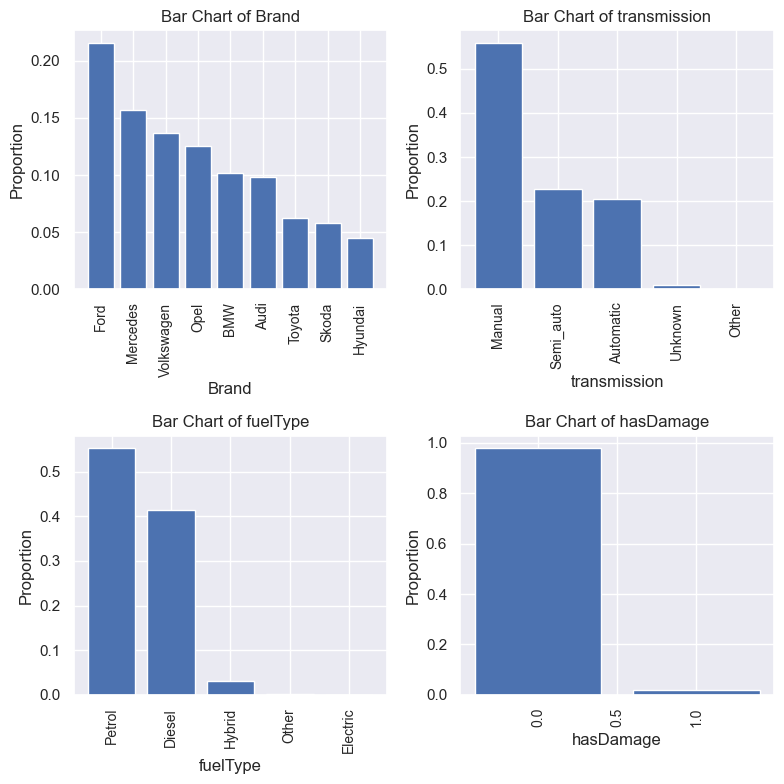

In [126]:

sns.set()

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

for i, var in enumerate([x for x in cat_feats if x != 'model']):  
    counts = df_train[var].value_counts()
    counts_scaled = counts / counts.sum()
    
    axes[i].bar(counts_scaled.index, counts_scaled.values)
    axes[i].set_title(f'Bar Chart of {var}')
    axes[i].set_xlabel(var)
    axes[i].tick_params(axis='x', rotation=90, labelsize=10)
    axes[i].set_ylabel('Proportion')

plt.tight_layout()  
plt.show()


Insights:
- Most of the cars in the data set are manual (~55%), followed by semi-automatic cars (~22%), automatic cars (~20%) and otherrs (3%)
- Most cars run on petrol and diesel
- Only a very small portion of the cars is not damaged.


When it comes to the values that do not make sense (i.e. errors) in the numerical categories we have to figure out a strategy.

In [127]:

errors = (
    (df_train['mileage'] < 0) |
    (df_train['tax'] < 0) |
    (df_train['paintQuality%'] > 100) |
    (df_train['previousOwners'] < 0) | (df_train['engineSize'] <= 0)
)

# Count how many rows meet at least one condition
count_invalid = errors.sum()
print(count_invalid)


print(f"The number of observations with invalid values accounts for {count_invalid/df_train.shape[0]*100}% of the training dataset.") 


# Eliminating these datapoints will result in a loss of ~2.3% which is quite a significant portion of the data set. However,
# these values are errors and make no sense in the context of the variables, so it might be a suitable choice
# to delete them. To be analysed later.


1732
The number of observations with invalid values accounts for 2.2797572821923575% of the training dataset.


Let's now do some box plots for the numerical features:

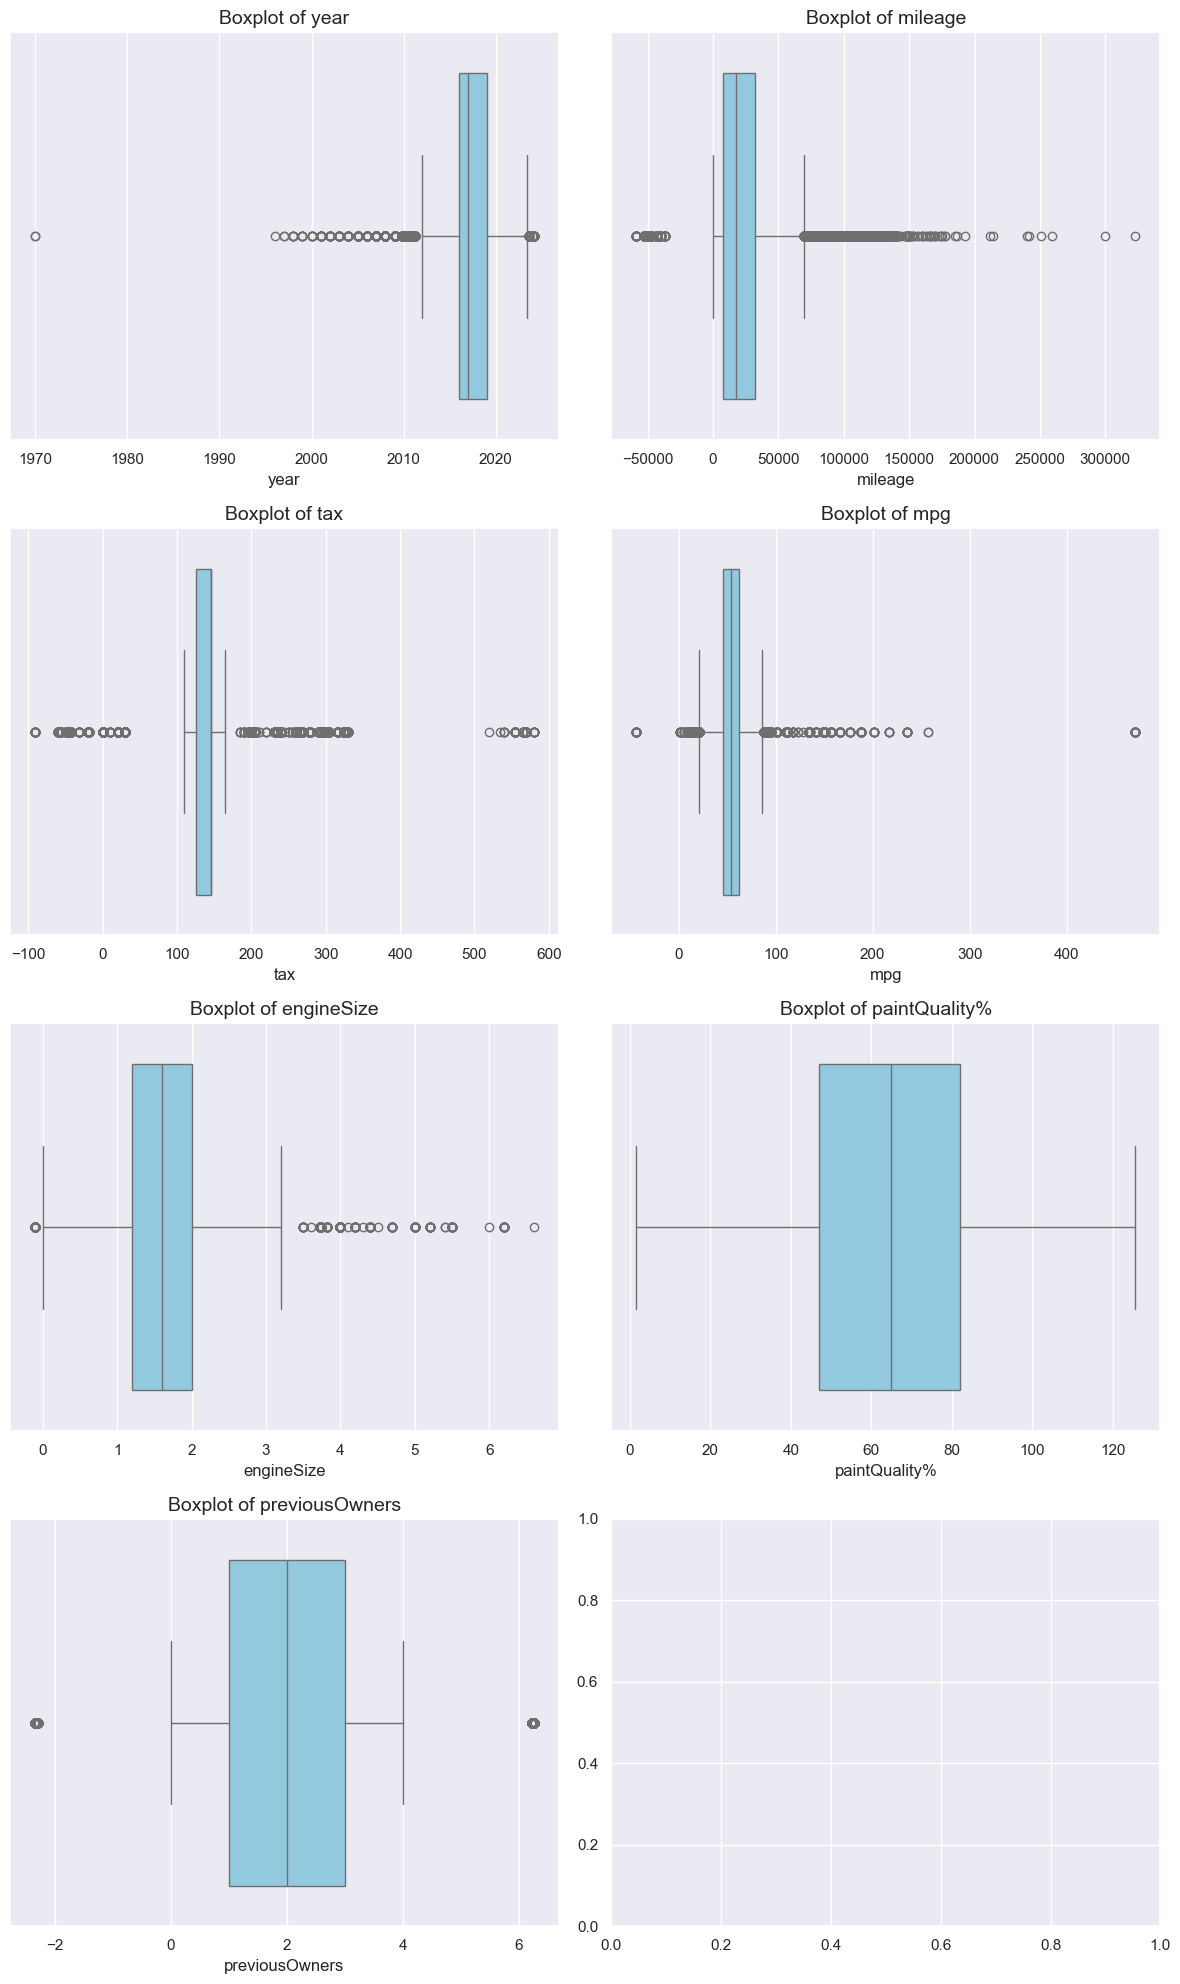

In [128]:

fig, axes = plt.subplots(4, 2, figsize=(12, 20))
axes = axes.flatten()

for i, var in enumerate(num_feats):
    sns.boxplot(x=df_train[var], ax=axes[i], orient='h', color='skyblue')
    axes[i].set_title(f'Boxplot of {var}', fontsize=14)
    axes[i].set_xlabel(var, fontsize=12)
    axes[i].set_ylabel('')  # hide y-axis label for clarity

plt.tight_layout()
plt.show()


We have outlirs on all of the numerical features except for previousOwners and paintQuality.

 **Year**

 This data base refers to the year 2020, so observations with years after 2020 are errors.

 **Mileage**

Most mileage values are valid, except for really high ones (maybe 300.000 or 250.000), which is almost equivalent to half a million km. A capping technique could be used in this case.

 **Tax**

 This variable has reasonable values (some cars are exempt of tax, high emmission cars pay a lot)

**mpg**

 Some very low values, which is not realistic for recent cars. Even for the older cars (from the 70s), the min should be around 10 mpg. Nowadays, mpg is around 50. We also have to take into account the presence of electric cars which don't really have an mpg value.

 **engineSize**

 Engine size values must be capped. The smallest engine size would be around 1L (Ford Fiesta) and biggest would be ~7L (BMW 7 Series).

 **paintQuality%**

 Should be okay with values between 0%-100%. 

 **previousOwners**

 Reasonable values.


Notes: 
lots of outlier older cars + lots of outlier high mileage cars
 


Getting the Spearson correlation matrix into a heat map:

                    year   mileage       tax       mpg  engineSize  \
year            1.000000 -0.780597  0.317446 -0.313547   -0.037248   
mileage        -0.780597  1.000000 -0.254982  0.322574    0.098192   
tax             0.317446 -0.254982  1.000000 -0.551523    0.160515   
mpg            -0.313547  0.322574 -0.551523  1.000000   -0.201771   
engineSize     -0.037248  0.098192  0.160515 -0.201771    1.000000   
paintQuality%   0.004975 -0.001336  0.004366  0.001541    0.003838   
previousOwners  0.001191  0.004020 -0.000583  0.001453    0.003925   

                paintQuality%  previousOwners  
year                 0.004975        0.001191  
mileage             -0.001336        0.004020  
tax                  0.004366       -0.000583  
mpg                  0.001541        0.001453  
engineSize           0.003838        0.003925  
paintQuality%        1.000000       -0.005642  
previousOwners      -0.005642        1.000000  


<AxesSubplot: >

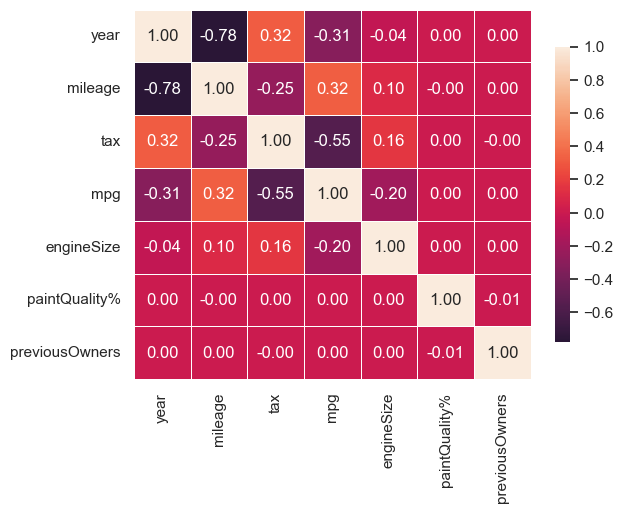

In [129]:
corr = df_train[num_feats].corr(method="spearman")
print(corr)

sns.heatmap(corr,annot=True,            
    fmt=".2f",            
    cmap="rocket",    
    center=0,        
    linewidths=0.5,       
    linecolor='white',      
    cbar_kws={"shrink": 0.8})

Mileage and year are highly correlated (in the negative direction - older cars -> higher mileage). Then mpg and year have some level of correllation but lower. A lot of the variables are not correlated at all.

# Multivariate Analysis

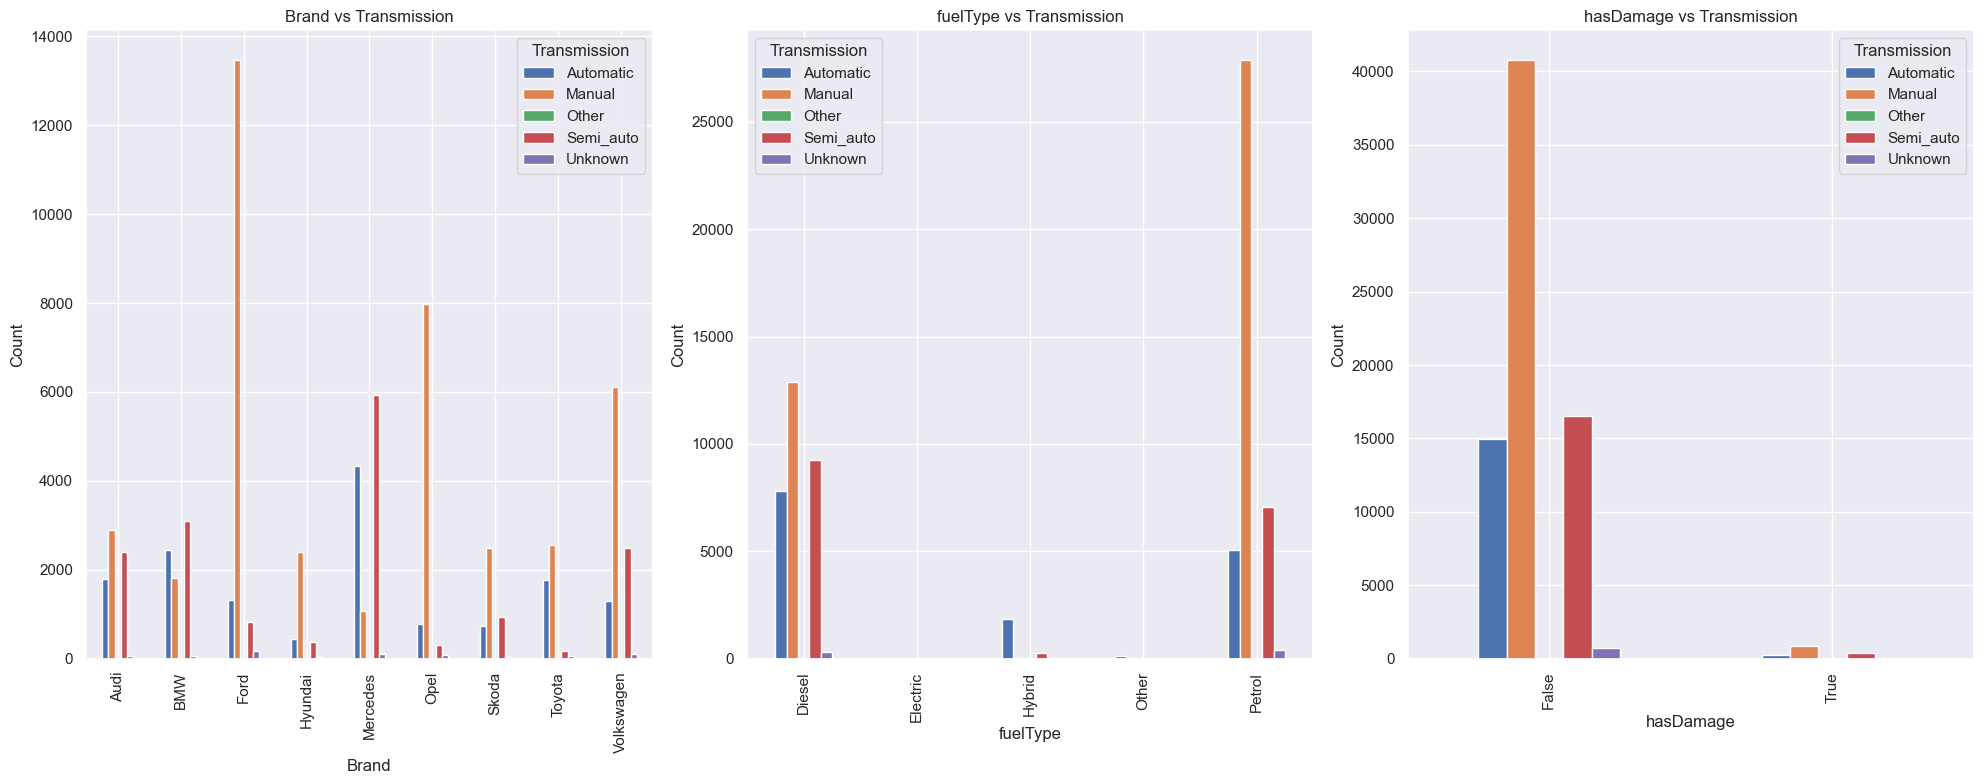

In [130]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))


plot_feats = [x for x in cat_feats if x not in ['model', 'transmission']]

for i, var in enumerate(plot_feats):
    
    ct = pd.crosstab(df_train[var], df_train['transmission'])
    
    
    ct.plot(kind='bar', ax=axes[i])
    
    axes[i].set_title(f"{var} vs Transmission")
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='Transmission')

plt.tight_layout()
plt.show()



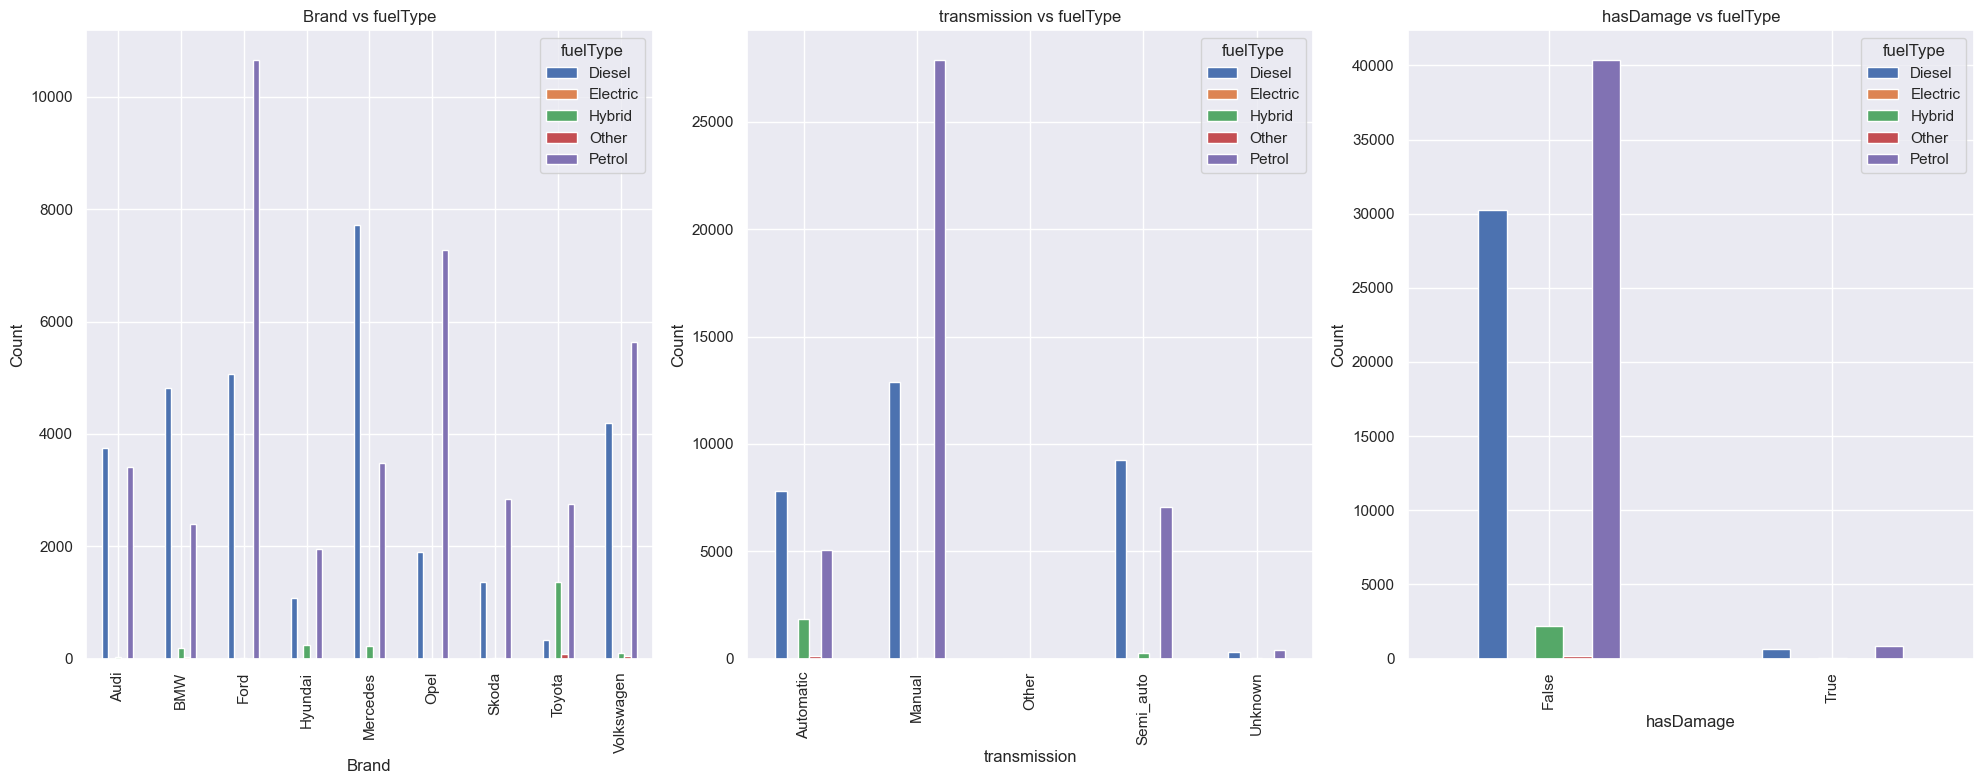

In [131]:

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# choose categorical features except model & fuelType (you can adjust as needed)
plot_feats = [x for x in cat_feats if x not in ['model', 'fuelType']]

for i, var in enumerate(plot_feats):
    # cross-tabulate the counts of each category vs transmission type
    ct = pd.crosstab(df_train[var], df_train['fuelType'])
    
    # plot as grouped bar chart
    ct.plot(kind='bar', ax=axes[i])
    
    axes[i].set_title(f"{var} vs fuelType")
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')


plt.tight_layout()
plt.show()


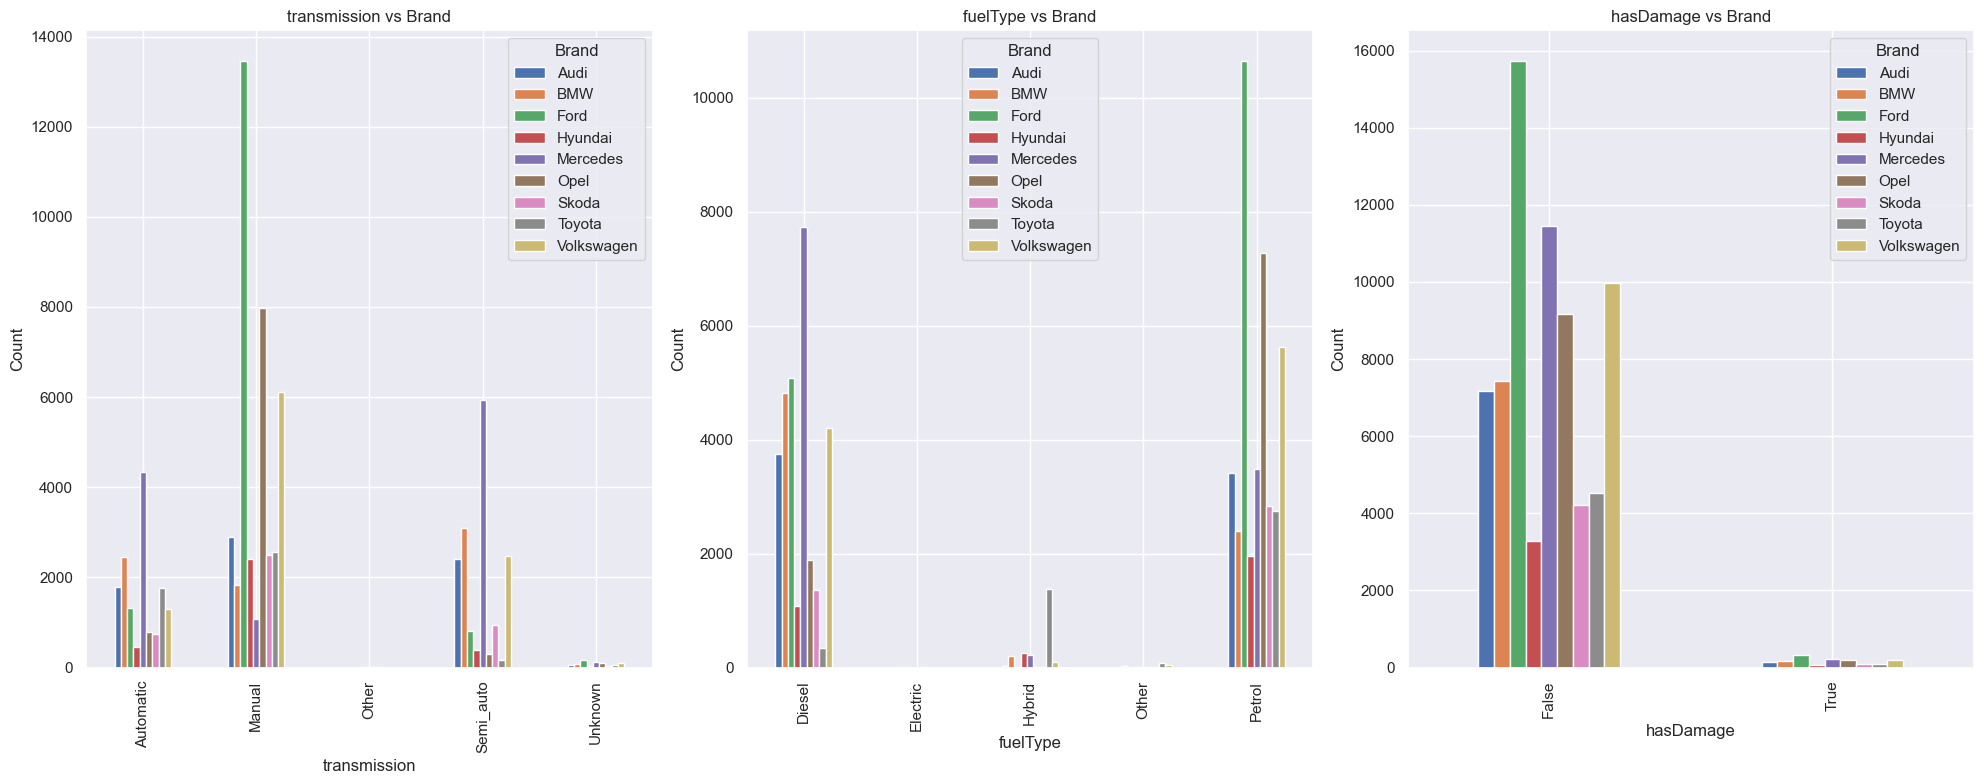

In [132]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# choose categorical features except model & fuelType (you can adjust as needed)
plot_feats = [x for x in cat_feats if x not in ['model', 'Brand']]

for i, var in enumerate(plot_feats):
    # cross-tabulate the counts of each category vs transmission type
    ct = pd.crosstab(df_train[var], df_train['Brand'])
    
    # plot as grouped bar chart
    ct.plot(kind='bar', ax=axes[i])
    
    axes[i].set_title(f"{var} vs Brand")
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')


plt.tight_layout()
plt.show()

Scatter plots of numerical variables 

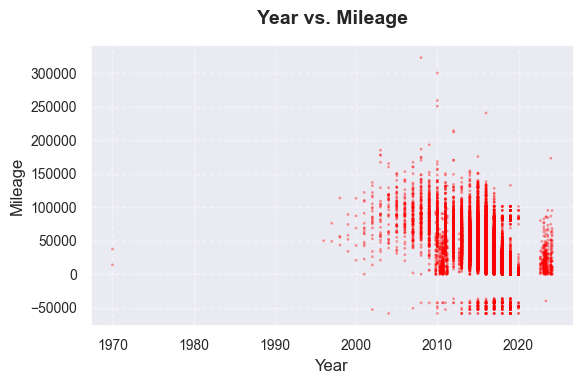

In [133]:

plt.figure(figsize=(6,4))

# Scatter plot
plt.scatter(
    df_train['year'],
    df_train['mileage'],
    s=4,                    
    alpha=0.4,              
    edgecolor='none',color='red',       
)

# Titles and labels
plt.title('Year vs. Mileage', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mileage', fontsize=12)

# Grid for easier reading
plt.grid(True, linestyle='--', alpha=0.5)

# Cleaner axis style
plt.tick_params(axis='both', which='major', labelsize=10)

# Layout and show
plt.tight_layout()
plt.show()


- The cars from 1970 are only outliers in 'year', not in 'mileage'.
- There are also a lot of outliers just in 'mileage' and not in 'year'
- As we have seen there's a lot of impossible mileage values (lower than zero).
- There's also a lot of cars from years after 2020.

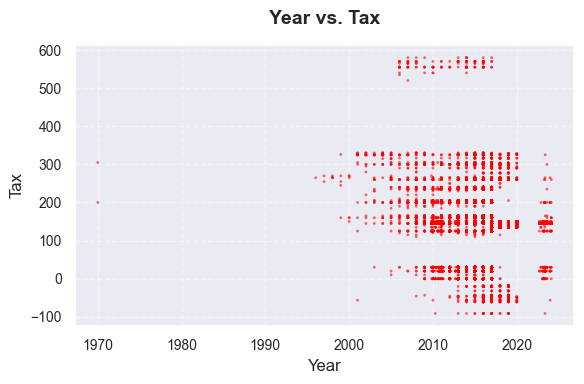

In [134]:
plt.figure(figsize=(6,4))

# Scatter plot
plt.scatter(
    df_train['year'],
    df_train['tax'],
    s=4,                     
    alpha=0.6,               
    edgecolor='none',color='red',       
)

# Titles and labels
plt.title('Year vs. Tax', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Tax', fontsize=12)

# Grid for easier reading
plt.grid(True, linestyle='--', alpha=0.5)

# Cleaner axis style
plt.tick_params(axis='both', which='major', labelsize=10)

# Layout and show
plt.tight_layout()
plt.show()

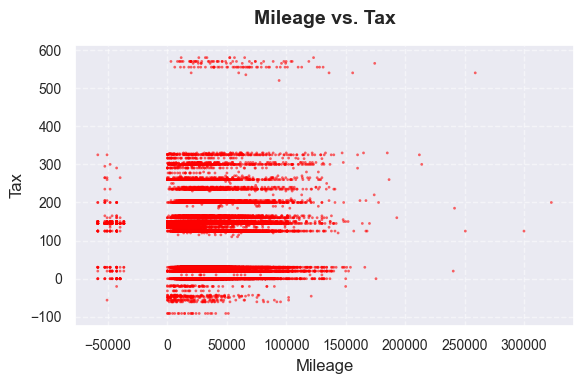

In [135]:
plt.figure(figsize=(6,4))

# Scatter plot
plt.scatter(
    df_train['mileage'],
    df_train['tax'],
    s=4,                     
    alpha=0.6,               
    edgecolor='none',color='red',       
)

# Titles and labels
plt.title('Mileage vs. Tax', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Mileage', fontsize=12)
plt.ylabel('Tax', fontsize=12)

# Grid for easier reading
plt.grid(True, linestyle='--', alpha=0.5)

# Cleaner axis style
plt.tick_params(axis='both', which='major', labelsize=10)

# Layout and show
plt.tight_layout()
plt.show()

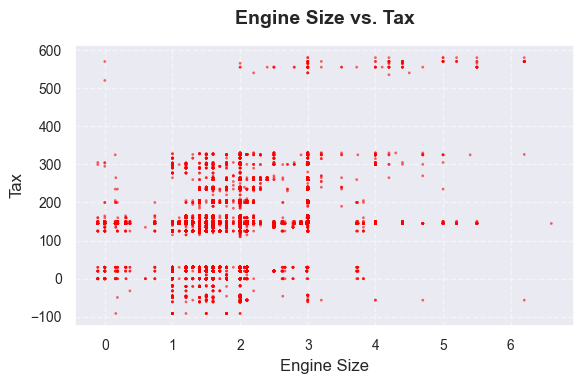

In [136]:
plt.figure(figsize=(6,4))

# Scatter plot
plt.scatter(
    df_train['engineSize'],
    df_train['tax'],
    s=4,                     
    alpha=0.6,               
    edgecolor='none',color='red',       
)

# Titles and labels
plt.title('Engine Size vs. Tax', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Engine Size', fontsize=12)
plt.ylabel('Tax', fontsize=12)

# Grid for easier reading
plt.grid(True, linestyle='--', alpha=0.5)

# Cleaner axis style
plt.tick_params(axis='both', which='major', labelsize=10)

# Layout and show
plt.tight_layout()
plt.show()

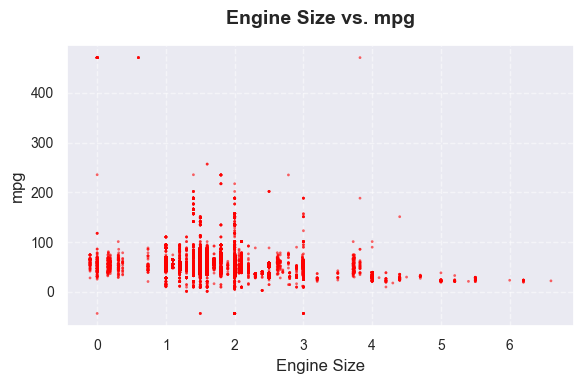

In [137]:
plt.figure(figsize=(6,4))

# Scatter plot
plt.scatter(
    df_train['engineSize'],
    df_train['mpg'],
    s=4,                     
    alpha=0.6,               
    edgecolor='none',color='red',       
)

# Titles and labels
plt.title('Engine Size vs. mpg', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Engine Size', fontsize=12)
plt.ylabel('mpg', fontsize=12)

# Grid for easier reading
plt.grid(True, linestyle='--', alpha=0.5)

# Cleaner axis style
plt.tick_params(axis='both', which='major', labelsize=10)

# Layout and show
plt.tight_layout()
plt.show()

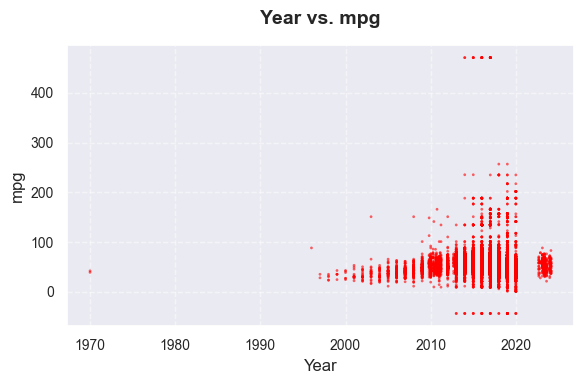

In [138]:
plt.figure(figsize=(6, 4))

# Scatter plot
plt.scatter(
    df_train['year'],
    df_train['mpg'],
    s=4,                     
    alpha=0.6,               
    edgecolor='none',color='red',       
)

# Titles and labels
plt.title('Year vs. mpg', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('mpg', fontsize=12)

# Grid for easier reading
plt.grid(True, linestyle='--', alpha=0.5)

# Cleaner axis style
plt.tick_params(axis='both', which='major', labelsize=10)

# Layout and show
plt.tight_layout()
plt.show()